<font size=5>**Turbofan engine Remaining Useful Lifetime prediction**</font>

![](../reports/figures/turbo.png)
![](../reports/figures/turbofan_schema.png)

__Pipeline__ : 
> - Linear Regression
> - Support vector Machine
> - Multi Layer Perceptron
> - Random Forest (?)

### Import libraries

In [33]:
import glob
import numpy as np # scientifique computation
import pandas as pd # data manipulation
from matplotlib import pyplot as plt # dataviz
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

# split dataset & prepare 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline

# ML model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# DL model
from sklearn.neural_network import MLPRegressor

# metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

# to display all the columns of the dataframe in the notebook
pd.set_option('display.max_columns', None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_to_interim = '../data/interim/'
files = sorted(glob.glob(path_to_interim+'*'))

# upload dataset
df = pd.read_csv(files[0])

# choose relevant features
to_drop = ['engine_id', 'time_cycle', 'max_cycle'] # id/label cols
cst_features = ['op_set_3', 'sensor_18', 'sensor_19'] # constant features
quasi_cst_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16'] # quasi-constant features
high_corr = ['sensor_9','sensor_14'] # core speed (sensor 9) & corrected core speed (sensor 14)
discreet_features = ['op_set_2', 'sensor_17']

# keep the ones to use for ML
cols_to_keep = [x for x in df.columns if x not in 
                to_drop + cst_features + quasi_cst_features + [high_corr[1]] + ['HI']]

# cols_to_keep_2 = [x for x in df.columns if x not in 
#                 to_drop + cst_features + quasi_cst_features + high_corr_to_drop + discreet_features]

In [3]:
# assign target and features
y = df['RUL']
X = df[cols_to_keep[:-2]]

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# shape of train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16504, 14) (4127, 14)
(16504,) (4127,)


In [4]:
def predict_y_RUL(pipe):
    
    # predict
    y_pred = pipe.predict(X_test)
    y_test.reset_index(drop=True)

    # create RUL df to compute error,d and score,s
    RUL = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=True )
    RUL.rename(columns={0:'true', 1:'estimated'}, inplace=True)

    # cast as int
    RUL['estimated'] = [int(i) for i in RUL['estimated']]

    # compute error d
    RUL['error'] = RUL['estimated'] - RUL['true']
    
    # stock as RUL dataframe
    return RUL

# plot rul true vs estimated
def plot_rul_true_estimated(RUL):
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=RUL, x='true', y='estimated', alpha=0.5)
    sns.lineplot(x=np.arange(-50,350), y=np.arange(-50,350), color = 'red')
    plt.xlim(-50,350)
    plt.ylim(-50,350)
    plt.grid()
    plt.show()

### Benchmark pipeline - Linear regression

R² score : 0.6102008004158257
MSE      : 1842.2609698697768


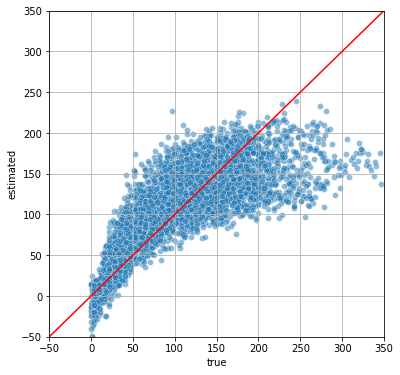

In [27]:
# define steps
steps_lr = [('polynomial', PolynomialFeatures(2, interaction_only=True)),
            ('scaler', StandardScaler()),
            ('estimator', LinearRegression())]

# instanciate pipeline
pipe_lr = Pipeline(steps=steps_lr)

# fit
pipe_lr.fit(X_train, y_train)

# predict
pipe_lr.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_lr.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_lr.predict(X_test))}')

# get rul dataframe
predict_y_RUL(pipe=pipe_lr)

# plot rul
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_lr))

In [28]:
pipe_lr.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('polynomial', PolynomialFeatures(interaction_only=True)),
                ('scaler', StandardScaler()),
                ('estimator', LinearRegression())])>

#### Gridsearch Linear Regression

In [36]:
param_grid = { 'polynomial__degree' : [2,3,4]
             }
grid = GridSearchCV(pipe_lr, param_grid, cv=3, verbose=10)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] polynomial__degree=2 ............................................
[CV] ................ polynomial__degree=2, score=0.619, total=   0.2s
[CV] polynomial__degree=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................ polynomial__degree=2, score=0.617, total=   0.2s
[CV] polynomial__degree=2 ............................................
[CV] ................ polynomial__degree=2, score=0.612, total=   0.2s
[CV] polynomial__degree=3 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] ................ polynomial__degree=3, score=0.613, total=   0.8s
[CV] polynomial__degree=3 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] ................ polynomial__degree=3, score=0.590, total=   0.6s
[CV] polynomial__degree=3 ............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s


[CV] ................ polynomial__degree=3, score=0.600, total=   2.0s
[CV] polynomial__degree=4 ............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.9s remaining:    0.0s


[CV] ................ polynomial__degree=4, score=0.554, total=   5.6s
[CV] polynomial__degree=4 ............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.6s remaining:    0.0s


[CV] ................ polynomial__degree=4, score=0.457, total=   5.4s
[CV] polynomial__degree=4 ............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.9s remaining:    0.0s


[CV] ................ polynomial__degree=4, score=0.526, total=   4.4s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LinearRegression())]),
             param_grid={'polynomial__degree': [2, 3, 4]}, verbose=10)

In [37]:
print(f'Best score : {grid.best_score_}')
print(f'\nBest parameters : {grid.best_params_}')

Best score : 0.6158742653153793

Best parameters : {'polynomial__degree': 2}


### Pipeline - Support Vector Regressor

R² score : 0.600150033151503
MSE      : 1889.7626996528527


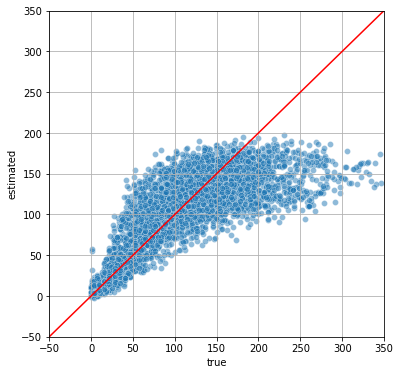

In [6]:
# define pipeline steps
steps_svr = [('scaler', StandardScaler()),
            ('estimator', SVR())]

pipe_svr = Pipeline(steps=steps_svr)

# fit
pipe_svr.fit(X_train, y_train)

# predict
pipe_svr.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_svr.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_svr.predict(X_test))}')

predict_y_RUL(pipe=pipe_svr)

plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_svr))

#### Gridsearch SVR

In [43]:
param_grid_svr = { 'estimator__kernel' : ['rbf', 'poly', 'linear' ],
                  'estimator__C' : [0.01, 0.1, 1]
             }

grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, verbose=10)
grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] estimator__C=0.01, estimator__kernel=rbf ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__C=0.01, estimator__kernel=rbf, score=0.155, total=   9.7s
[CV] estimator__C=0.01, estimator__kernel=rbf ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=rbf, score=0.150, total=   9.4s
[CV] estimator__C=0.01, estimator__kernel=rbf ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=rbf, score=0.156, total=  10.2s
[CV] estimator__C=0.01, estimator__kernel=rbf ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.3s remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=rbf, score=0.168, total=  10.5s
[CV] estimator__C=0.01, estimator__kernel=rbf ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.8s remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=rbf, score=0.152, total=  11.4s
[CV] estimator__C=0.01, estimator__kernel=poly .......................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.2s remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=poly, score=0.310, total=   9.1s
[CV] estimator__C=0.01, estimator__kernel=poly .......................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=poly, score=0.312, total=  10.1s
[CV] estimator__C=0.01, estimator__kernel=poly .......................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=poly, score=0.308, total=   9.9s
[CV] estimator__C=0.01, estimator__kernel=poly .......................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=poly, score=0.327, total=   9.2s
[CV] estimator__C=0.01, estimator__kernel=poly .......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  estimator__C=0.01, estimator__kernel=poly, score=0.304, total=   9.3s
[CV] estimator__C=0.01, estimator__kernel=linear .....................
[CV]  estimator__C=0.01, estimator__kernel=linear, score=0.548, total=   7.6s
[CV] estimator__C=0.01, estimator__kernel=linear .....................
[CV]  estimator__C=0.01, estimator__kernel=linear, score=0.555, total=   8.0s
[CV] estimator__C=0.01, estimator__kernel=linear .....................
[CV]  estimator__C=0.01, estimator__kernel=linear, score=0.555, total=   8.1s
[CV] estimator__C=0.01, estimator__kernel=linear .....................
[CV]  estimator__C=0.01, estimator__kernel=linear, score=0.571, total=   7.5s
[CV] estimator__C=0.01, estimator__kernel=linear .....................
[CV]  estimator__C=0.01, estimator__kernel=linear, score=0.542, total=   7.9s
[CV] estimator__C=0.1, estimator__kernel=rbf .........................
[CV]  estimator__C=0.1, estimator__kernel=rbf, score=0.504, total=  11.0s
[CV] estimator__C=0.1, estimator__

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', SVR())]),
             param_grid={'estimator__C': [0.01, 0.1, 1],
                         'estimator__kernel': ['rbf', 'poly', 'linear']},
             verbose=10)

In [45]:
print(f'Best score : {grid_svr.best_score_}')
print(f'\nBest parameters : {grid_svr.best_params_}')

Best score : 0.6057086530134056

Best parameters : {'estimator__C': 1, 'estimator__kernel': 'rbf'}


### Pipeline - Multi-layer Perceptron

/home/hazmilh/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


R² score : 0.6294559441874604
MSE      : 1751.25770491296


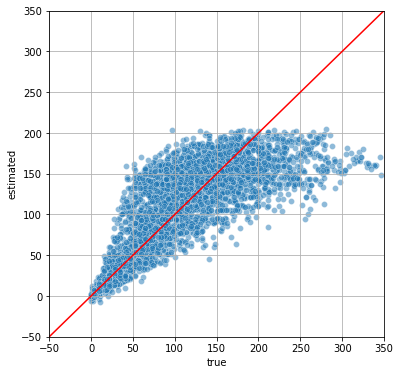

In [7]:
# define steps
steps_mlp = [('scaler', StandardScaler()),
            ('estimator', MLPRegressor(hidden_layer_sizes=(100,100), activation='tanh'))]

# instanciate pipeline
pipe_mlp = Pipeline(steps=steps_mlp)

# fit
pipe_mlp.fit(X_train, y_train)

# predict
pipe_mlp.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_mlp.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_mlp.predict(X_test))}')

predict_y_RUL(pipe=pipe_mlp)

plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_mlp))

### Pipeline - Random Forest

R² score : 0.6214049782269954
MSE      : 1789.3080148534043


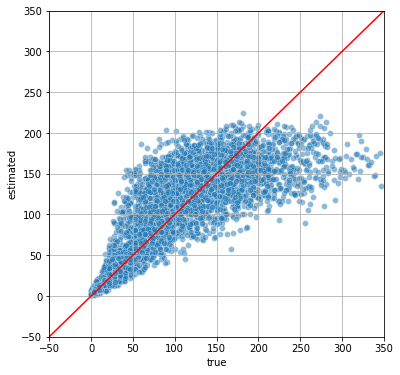

In [12]:
# define pipeline steps
steps_rf = [('scaler', StandardScaler()),
            ('estimator', RandomForestRegressor(max_depth=100, random_state=1234))]

# instanciate
pipe_rf = Pipeline(steps=steps_rf)

# fit
pipe_rf.fit(X_train, y_train)

# predict
pipe_rf.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_rf.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_rf.predict(X_test))}')

predict_y_RUL(pipe=pipe_rf)

plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_rf))

### Score comparisons

R² linear regression : 0.6102008002952546
R² SVR               : 0.600150033151503
R² MLP               : 0.6294559441874604
R² RF                : 0.6214049782269954

MSE linear regression : 1842.260970439618
MSE SVR               : 1889.7626996528527
MSE MLP               : 1751.25770491296
MSE RF                : 1789.3080148534043


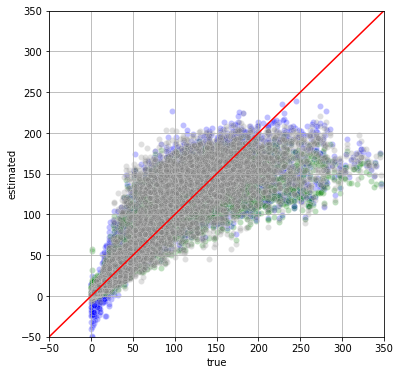

In [14]:
# R2 score
print(f'R² linear regression : {pipe_lr.score(X_test, y_test)}')
print(f'R² SVR               : {pipe_svr.score(X_test, y_test)}')
print(f'R² MLP               : {pipe_mlp.score(X_test, y_test)}')
print(f'R² RF                : {pipe_rf.score(X_test, y_test)}')
# mean square error
print(f'\nMSE linear regression : {mean_squared_error(y_test, pipe_lr.predict(X_test))}')
print(f'MSE SVR               : {mean_squared_error(y_test, pipe_svr.predict(X_test))}')
print(f'MSE MLP               : {mean_squared_error(y_test, pipe_mlp.predict(X_test))}')
print(f'MSE RF                : {mean_squared_error(y_test, pipe_rf.predict(X_test))}')

RUL_lr = predict_y_RUL(pipe=pipe_lr)
RUL_svr = predict_y_RUL(pipe=pipe_svr)
RUL_mlp = predict_y_RUL(pipe=pipe_mlp)
RUL_rf = predict_y_RUL(pipe=pipe_rf)

plt.figure(figsize=(6,6))

sns.scatterplot(data=RUL_lr, x='true', y='estimated', alpha=0.25, color='blue')
sns.scatterplot(data=RUL_svr, x='true', y='estimated', alpha=0.25, color='green')
sns.scatterplot(data=RUL_mlp, x='true', y='estimated', alpha=0.25, color='gray')
sns.scatterplot(data=RUL_rf, x='true', y='estimated', alpha=0.25, color='gray')

sns.lineplot(x=np.arange(-50,350), y=np.arange(-50,350), color = 'red')
plt.xlim(-50,350)
plt.ylim(-50,350)
plt.grid()
plt.show()

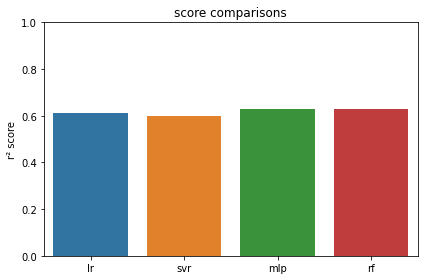

In [10]:
plt.figure(figsize=(6,4))
plt.title('score comparisons')

scores = [pipe_lr.score(X_test, y_test),
          pipe_svr.score(X_test, y_test),
          pipe_mlp.score(X_test, y_test),
          pipe_rf.score(X_test, y_test)
         ]

sns.barplot(y=scores, x=['lr', 'svr', 'mlp', 'rf'])
plt.ylim(0,1)
plt.ylabel('r² score')
plt.tight_layout()
plt.show()